In [1]:
from matplotlib.patches import Polygon as MplPolygon
import matplotlib.pyplot as plt

from scipy.interpolate import splprep, splev

import gpflow
import numpy as np 
import tensorflow as tf
gpflow.config.set_default_float(np.float32)
np.random.seed(1234)
tf.random.set_seed(1234)

from sgptools.methods import *
from sgptools.kernels import get_kernel
from sgptools.utils.misc import *
from sgptools.utils.metrics import *
from sgptools.utils.data import Dataset
from sgptools.utils.gpflow import get_model_params
from hex import *

2025-12-07 20:57:15.679607: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-07 20:57:16.050035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765162636.169035   10449 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765162636.206274   10449 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765162636.503004   10449 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def get_grid(X_data, num_x, num_y):
    grid_x, grid_y = np.mgrid[min(X_data[:, 0]):max(X_data[:, 0]):complex(num_x), 
                              min(X_data[:, 1]):max(X_data[:, 1]):complex(num_y)]
    X_grid = np.stack([grid_x, grid_y], axis=-1)
    return X_grid.reshape(-1, 2).astype(X_data.dtype)

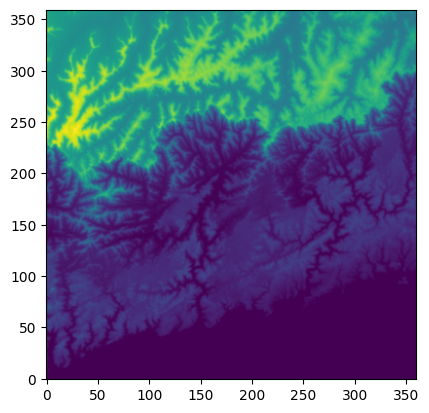

Original dataset shape: (360, 360)
Training data shapes (X, y): (5000, 2), (5000, 1)
Testing data shapes (X, y): (2500, 2), (2500, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.


In [3]:
# Load data
data = np.load("N17E073.npy")
plt.imshow(data.T, origin="lower")
plt.show()

# Get dataset
dataset = Dataset(data=data, dtype=np.float32,
                  num_train=5000)
X_train, y_train = dataset.get_train()
del data

In [4]:
# Generate X_init
waypoints = get_inducing_pts(X_train, num_inducing=15)
waypoints, _ = run_tsp(waypoints)
waypoints = waypoints[0]
tck, u = splprep([waypoints[:, 0], waypoints[:, 1]], s=0)
u_fine = np.linspace(0, 1, 250)
X_init = np.stack([splev(u_fine, tck)]).T
X_init = X_init[:, :, 0].astype(X_train.dtype)
X_init, y_init = dataset.get_sensor_data(X_init,
                                         max_samples=len(X_init))
print("Init Set Dims:", X_init.shape)

# Generate X_test
x_dim, y_dim = 100, 100
X_grid = get_grid(X_train, x_dim, y_dim)
X_grid, y_grid = dataset.get_sensor_data(X_grid,
                                         max_samples=len(X_grid))
print("Grid Set Dims:", X_grid.shape)

# Generate X_cand (grid with spacing set to minimum radius)
min_r = 1/2
x_max, y_max = X_train.max(axis=0)
x_min, y_min = X_train.min(axis=0)

cand_x_dim = np.ceil((x_max-x_min)/min_r).astype(int)
cand_y_dim = np.ceil((y_max-y_min)/min_r).astype(int)
X_cand = get_grid(X_train, cand_x_dim, cand_y_dim)

print("Candidate Set Dims:", X_cand.shape)
print(f"Minumum Radius: {min_r:.2f}")

# Get the extent for potting
extent = [min(X_train[:, 0]), max(X_train[:, 0]), 
          min(X_train[:, 1]), max(X_train[:, 1])]

Init Set Dims: (250, 2)
Grid Set Dims: (10000, 2)
Candidate Set Dims: (4900, 2)
Minumum Radius: 0.50


In [5]:
_, noise_variance, kernel, init_model = get_model_params(
    X_train=X_init, y_train=y_init, 
    kernel=get_kernel('RBF')(),
    optimizer='tf.Nadam',
    learning_rate=1e-2,
    max_steps=1000,
    return_model=True,
    verbose=True)

2025-12-07 20:57:28.349695: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float32 │ 0.570367  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float32 │ 4.76992   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float32 │ 0.0789746 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧════════════

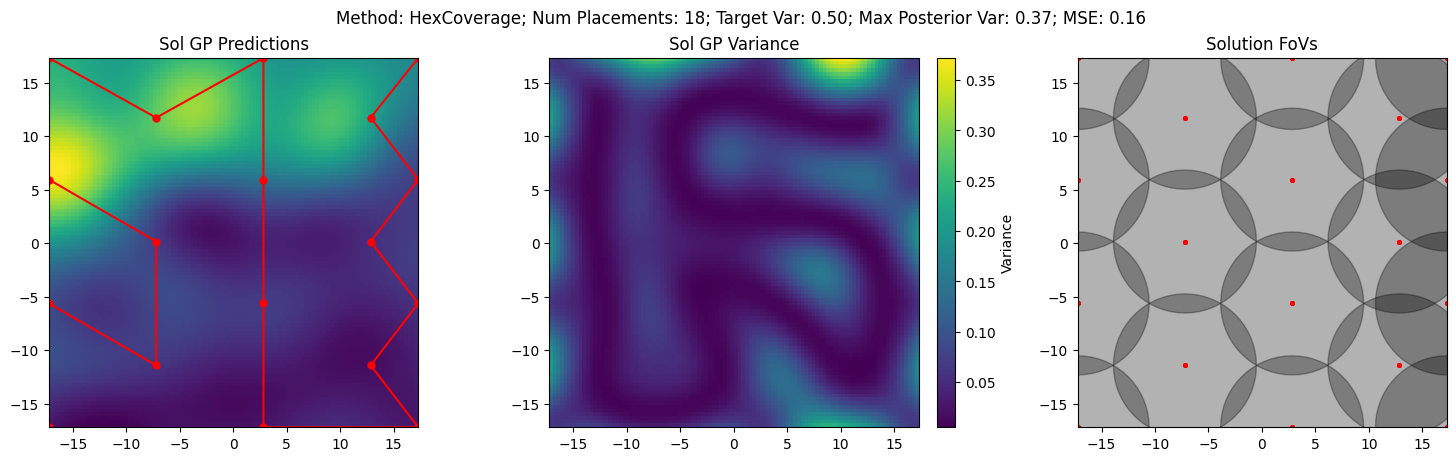

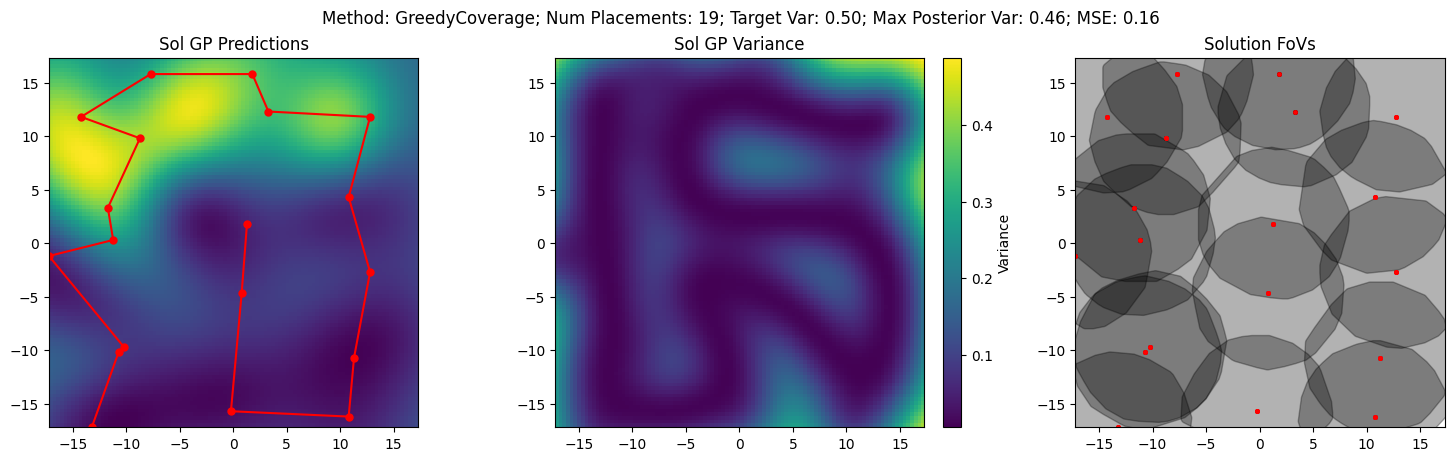

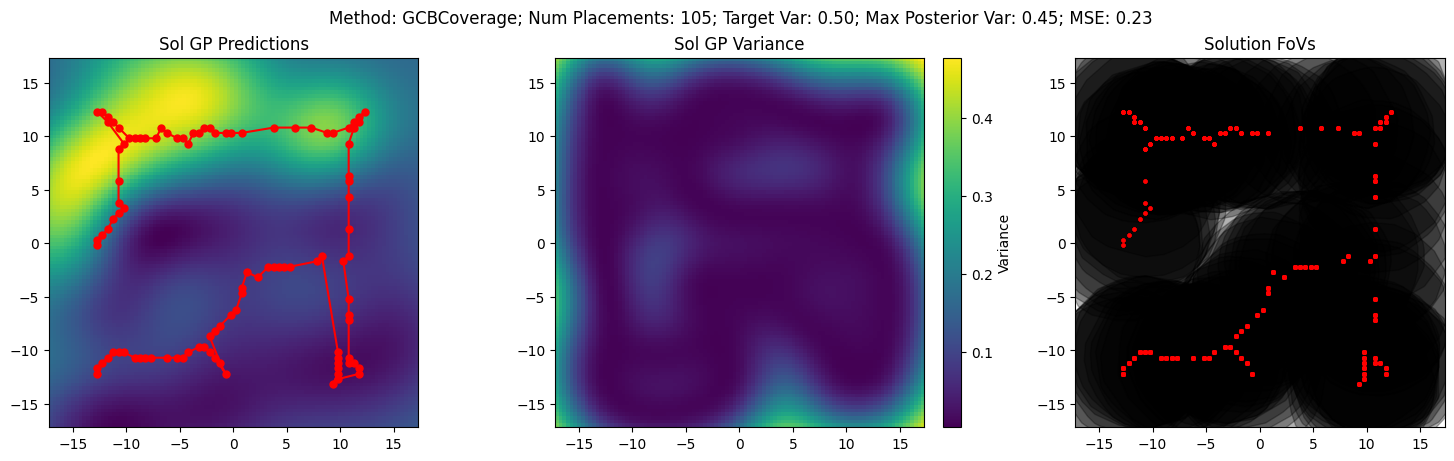

In [6]:
var_threshold = 0.5
for method in ['HexCoverage', 'GreedyCoverage', 'GCBCoverage']:
    cmodel = get_method(method)(num_sensing=500,
                                X_objective=X_train,
                                kernel=kernel,
                                noise_variance=noise_variance,
                                X_candidates=X_cand)
    X_sol, fovs = cmodel.optimize(var_threshold=var_threshold, 
                                  return_fovs=True)
    X_sol = X_sol[0]
    X_pred, y_pred = dataset.get_sensor_data(X_sol,
                                             max_samples=len(X_sol))

    _, _, _, model_sol = get_model_params(
        X_train=np.vstack([X_pred, X_init]), 
        y_train=np.vstack([y_pred, y_init]), 
        kernel=kernel,
        noise_variance=noise_variance,
        max_steps=0,
        return_model=True,
        verbose=False)
    mean, var = model_sol.predict_f(X_grid)
    _, train_var = model_sol.predict_f(X_train)

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), constrained_layout=True)

    # First subplot — training data
    sc1 = axes[0].imshow(mean.numpy().reshape(x_dim, y_dim).T, 
                         extent=extent, origin="lower")
    axes[0].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=25)
    axes[0].plot(X_sol[:, 0], X_sol[:, 1], c='r')
    axes[0].set_title("Sol GP Predictions")
    axes[0].set_aspect('equal')

    # Second subplot — Variance data
    sc2 = axes[1].imshow(var.numpy().reshape(x_dim, y_dim).T, 
                        extent=extent, origin="lower")
    axes[1].set_title("Sol GP Variance")
    axes[1].set_aspect('equal')
    fig.colorbar(sc2, ax=axes[1], orientation='vertical', 
                fraction=0.05, pad=0.04, label='Variance')

    # Third subplot — FoV data
    axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
    for fov in fovs:
        patch = MplPolygon(list(fov.exterior.coords), 
                        closed=True, 
                        facecolor='k', 
                        edgecolor='k', 
                        alpha=0.3)
        axes[2].add_patch(patch)
        axes[2].scatter(X_sol[:, 0], X_sol[:, 1], c='r', s=5)
    axes[2].set_title("Solution FoVs")
    axes[2].set_aspect('equal')
    axes[2].set_xlim(axes[1].get_xlim())
    axes[2].set_ylim(axes[1].get_ylim())

    fig.suptitle(f"Method: {method}; Num Placements: {len(fovs)}; Target Var: {var_threshold:.2f}; Max Posterior Var: {train_var.numpy().max():.2f}; MSE: {get_mse(mean.numpy(), y_grid):.2f}")
    plt.show()